## Lagrange interpolation

Given $(n+1)$ distinct points $\{X_i\}_{i=0}^n$ in the interval $[0,1]$,
we define the *Lagrange interpolation* operator $\mathcal{L}^n$ the operator
$$
\mathcal{L}^n : C^0([0,1]) \mapsto \mathcal{P}^n
$$
which satisfies
$$
(\mathcal{L}^n f)(X_i) = f(X_i), \qquad i=0,\dots,n.
$$

This operator is used to approximate the infinitely dimensional space $C^0([0,1])$ with a
finite dimensional one, $\mathcal{P}^n$, which is the space of polynomials of order n. 

Such a space has dimension $n+1$, and can be constructed using linear combinations of 
$n+1$ linear independent polynomials of order $\leq n$, for example, the monomials:

$$
\mathcal{P}^n = \text{span}\{v_i := x^i\}_{i=0}^{n}
$$

If we want to construct the Lagrange interpolation of a given function on $n+1$ equispaced points in 
$[0,1]$, then we are actively looking for an element of $\mathcal{P}^n$ that coincides with the function
at these given points.

Given a basis $\{v_i\}_{i=0}^n$, any element of $\mathcal{P}^n$ can be written as a linear combination of 
the basis, i.e., 

$$
\forall p \in \mathcal{P}^n, \quad  \exists! \{p^i\}_{i=0}^n  \quad| \quad p(x) = \sum_{i=0}^n p^i v_i(x)
$$

in what follows, we'll use [Einstein summation convention](https://en.wikipedia.org/wiki/Einstein_notation), and 
call $p$ a function of $\mathcal{P}^n$, and $[p]$ the $R^{n+1}$ vector representing its coefficients. 

If we want to solve the interpolation problem above, then we need to find the coefficients $p^i$ of the 
polynomial $p$ that interpolates $f$ at the points $X_i$:

$$
v_j(X_i) p^j = f(X_i), \qquad \Longleftrightarrow \qquad [[V]][p] = [F]
$$

(Remember Einstein summation convention)

This can be written as a linear problem $[V] [p] = [F]$, with system matrix $[V]_{ij} :=  v_j(X_i)$ and right 
hand side $[F]_i = f(X_i)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [3]:
def build_lagrangian_basis(q, e):
  n_q_points = q.shape[0]
  n_e_points = e.shape[0]

  # basis[i, j] is the value of l[j] on the point e[i] where
  # l[j] is the lagrange polynomial that is 1 on q[j] and 0
  # on q[k] for k != j
  basis = np.ones((n_e_points, n_q_points), dtype=np.float64)

  for i in range(n_e_points):
    for j in range(n_q_points):
      for k in range(n_q_points):
        if k == j:
          continue
        basis[i, j] *= (e[i] - q[k]) / (q[j] - q[k])
  return basis

def lagrange_basis_function(nodes, i, x):
    nodes_except_i = np.delete(nodes, i)
    numerator = 1
    denominator = 1

    for other_node in nodes_except_i:
        numerator = numerator * (x - other_node)
        denominator = denominator * (nodes[i] - other_node)

    return numerator / denominator

def build_lagrangian_basis_sym(q, x):
  return [lagrange_basis_function(q, i, x) for i in range(len(q))]

def lambdify(x, f):
    f = sympy.lambdify([x], f, "numpy")
    return f
  

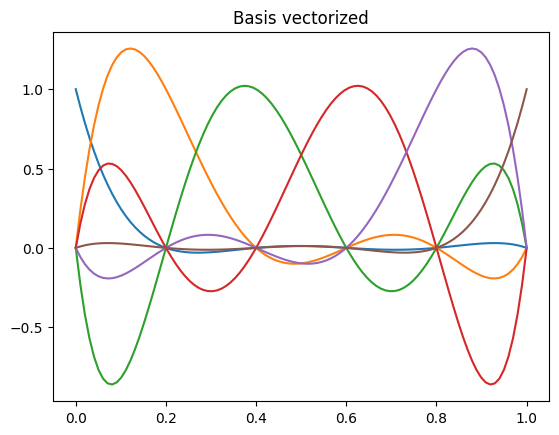

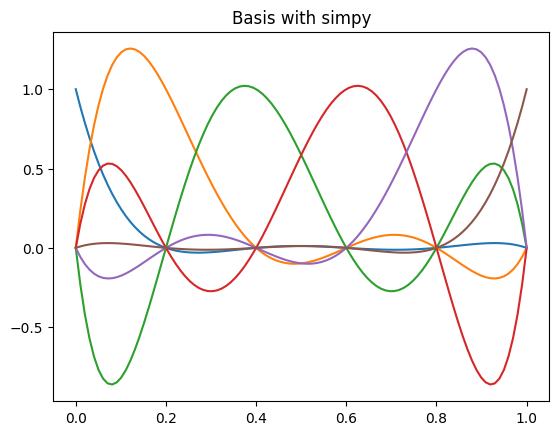

In [4]:
# Plot the Computed basis functions in the case
x = sympy.var("x")
e = np.linspace(0, 1, 100)
q = np.linspace(0, 1, 6)

basis = build_lagrangian_basis(q, e)
basis_sym = build_lagrangian_basis_sym(q,x)
basis_lam = []
# Transform basis to lambda function
for i in basis_sym:
    basis_lam.append(lambdify(x,i))
## Plot vectorized basis
plt.plot(e, basis)
plt.title("Basis vectorized")
## Plot basis with sympy
plt.figure()
plt.title("Basis with simpy")
for base in basis_lam:
    plt.plot(e,base(e))

In [25]:
# Define a function that computes the interpolation of a given function f
def interpolate(f, q, e):
  n_q_points = q.shape[0]
  n_e_points = e.shape[0]

  basis = build_lagrangian_basis(q, e)

  f_e = np.zeros((n_e_points,), dtype=np.float64)

  for i in range(n_e_points):
    for j in range(n_q_points):
      f_e[i] += basis[i, j] * f(q[j])
  return f_e

def interpolate_vec(f, q, e):
  basis = build_lagrangian_basis(q, e)
  return basis@f(q)

Use the functions above to interpolate the function $y = \sin(2\pi x)$, plot the results and compute the $L^2$ norm of the error

In [22]:
def f(x):
  return np.sin(2 * np.pi * x)

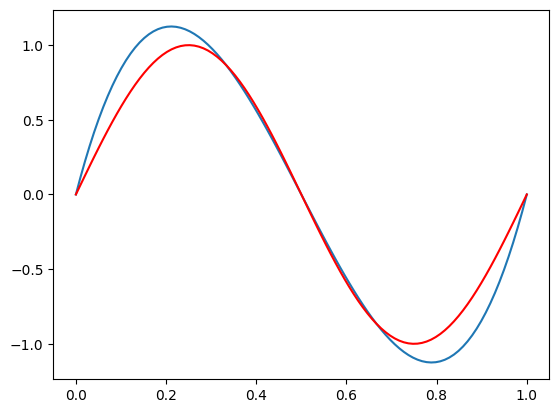

In [26]:
f_interp = interpolate_vec(f, q, e)
plt.plot(e, f_interp)
plt.plot(e, f(e), color="red")

In [27]:
# Given an interval I = [a,b] define a function that gives N Chebishev-Gauss points
def GaussChebishev(a,b,N):
    x = np.zeros(N+1)
    for k in range(N+1):
        tk = np.cos((2*k+1)/(2*N+2)*np.pi)
        x[k] = (a+b)/2 + (b-a)/2*tk
    return x

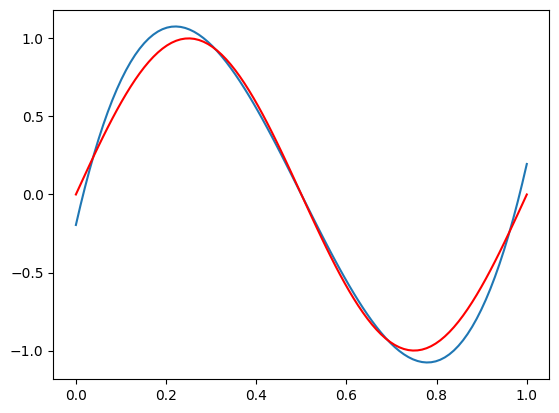

In [28]:
# Test the interpolation with the new points plotting the comparison and computing the error
q = GaussChebishev(0,1,3)

basis = build_lagrangian_basis(q, e)
f_interp = interpolate(f, q, e)
plt.plot(e, f_interp)
plt.plot(e, f(e), color="red")

In [29]:
# Given an interval I = [a,b] define a function that gives N Gauss-Chebishev-Lobatto points
def GaussChebishevLobatto(a,b,N):
    x = np.zeros(N+1)
    for k in range(N+1):
        tk = -np.cos(k*np.pi/N)
        x[k] = (a+b)/2 + (b-a)/2*tk
    return x

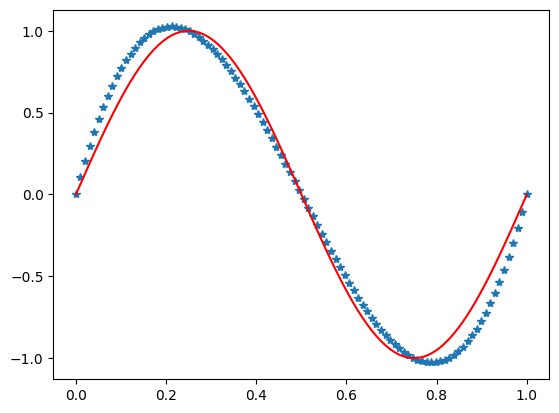

In [30]:
# Test the interpolation with the new points plotting the comparison and computing the error
q = GaussChebishevLobatto(0,1,3)
f_interp = interpolate(f, q, e)
plt.plot(e, f_interp, "*")
plt.plot(e, f(e), color="red")

Test the implement methods with the Runge $f(x) = \frac{1}{1+x^2}$ function in the interval $I = [-5,5]$


In [31]:
def runge(x):
    return 1/(1+x**2)

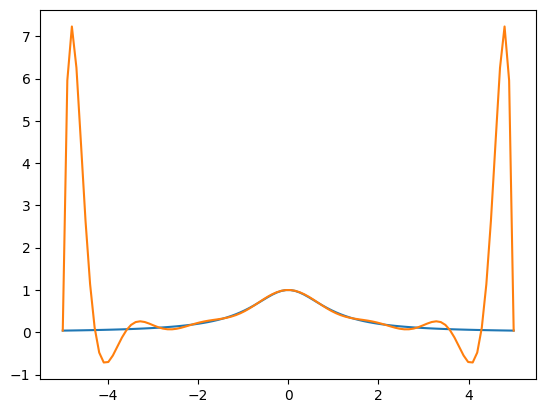

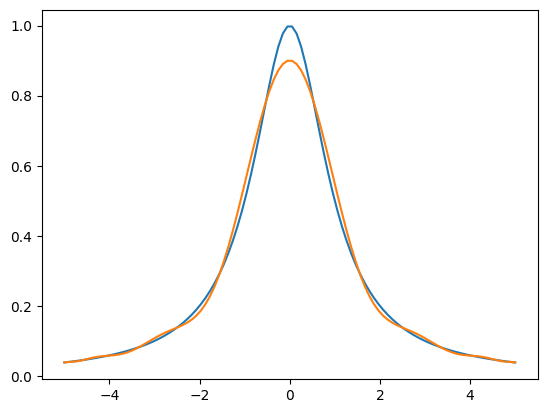

In [32]:
x = np.linspace(-5,5,100)
q = np.linspace(-5,5,15)
e = np.linspace(-5,5,100)

f_interp = interpolate(runge, q, e)

plt.plot(x,runge(x))
plt.plot(x,f_interp)

q = GaussChebishevLobatto(-5,5,15)

plt.figure()
f_interp = interpolate(runge, q, e)
plt.plot(x,runge(x))
plt.plot(x,f_interp)